# Ch. 3: Classification
***
***

We've done a regression example, which could provide a continous output. Now, we look at discrete outputs.

***

## 3.1 - Example Dataset: MNIST

### 3.1.1 - Downloading the Dataset

Here, we use MNIST!

- 70,000 imagits of handwritten digits
- Each image has already been classified
- "Hello, world!" of Machine Learning
- Baseline dataset for new classification algorithms

This can be imported with _sklearn_, _tensorflow_, or here:

http://yann.lecun.com/exdb/mnist/

Also, stackoverflow had a solution for if the sklearn download didn't work (which did not work for me initially):

In [16]:
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except Exception as ex:        
    from six.moves import urllib
    from scipy.io import loadmat
    import os

    mnist_path = os.path.join(".", "datasets", "mnist-original.mat")

    # download dataset from github.
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)

    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Done!")

Done!


### 3.1.2 - Dataset (MNIST) Structure

We can get a feel for the structure of the dataset below:

In [18]:
X, y = mnist["data"], mnist["target"]

print("MNIST Keys:", mnist.keys())
print("Input data structure (with features): ", X.shape)
print("Target data structure: ", y.shape)

MNIST Keys: dict_keys(['data', 'target', 'COL_NAMES', 'DESCR'])
Input data structure (with features):  (70000, 784)
Target data structure:  (70000,)


There's 70,000 images with 784 features (28x28 pixels with an intensity range from 0 to 255)

Let's plot a random image to see what sort of input picture we are looking at and see if that label matches the image:

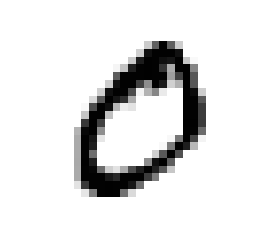

Corresponding Example Label:  0.0


In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt

ex_digit = X[0]
ex_digit_image = ex_digit.reshape(28, 28)

plt.imshow(ex_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

print("Corresponding Example Label: ", y[0])

This is a seriously complicated task if we were going to use _if-else_ statements. Let's not do that. 

### 3.1.3 - Splitting Training and Test Sets

MNIST is already split up into training and test sets (the first 60,000 as the training, the last 10,000 as the test). 

In [24]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Here, we can shuffle the training set to ensure cross-validation will not get multiple of the similar digits in a row. We want to make sure they are shuffled with the same corresponding index (not shuffled independently).

Apparently, this step isn't necessary as MNIST is already shuffled, but it's a good exercise!

In [25]:
import numpy as np

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

unison_shuffled_copies(X_train, y_train)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([1., 2., 3., ..., 2., 9., 3.]))

***
## 3.2 - Binary Classification

### 3.2.1 - Training a Binary Classifier (Ex. Stochastic Gradient Descent)

**Binary Classifier**: Is the object one thing or not? Yes or no?

Let's do 0 and not 0

In [51]:
y_train_0 = (y_train == 0)
y_test_0 = (y_test == 0)

_Stochastic Gradient Descent_ can handle large datasets efficiently as it deals with training sets independently (well suited for _online learning_).

https://en.wikipedia.org/wiki/Stochastic_gradient_descent

Let's start with that.

Creating an _SGDClassifier_ class from Scikit-Learn:

In [52]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_0)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

**If you want reproducible results with SGD, you need to set the initial random state to the same number as it will rely on random processes and not repeat itself otherwise**

Now, we will use it to detect a zero in our sample image:

In [53]:
sgd_clf.predict(ex_digit.reshape(1,-1))

array([ True])

Christ on a cracker it worked! How about nabbing some performance metrics across the rest of the dataset?

### 3.2.2 - Performance Metrics

A lot harder than evaluating a regression model.

#### 3.2.2.1 - Measuring Accuracy Using Cross-Validation

We implemented this in the second chapter with a pre-written function from Scikit, but we can write our own if the data we are working with won't play nice.

Remember, sklearn can use _StratifiedKFold_ to construct representative ratios of each class. Our code will train on each separate fold of the data and then make predictions in the test fold. 

In [54]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_0):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_0[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_0[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print("Percentage Correct, SGD Classifier: ", (n_correct / len(y_pred))*100)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Percentage Correct, SGD Classifier:  97.98510074496275


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Percentage Correct, SGD Classifier:  91.705


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Percentage Correct, SGD Classifier:  96.98484924246212


It looks like we have the lowest score at ~91%. Not bad. Remember that there are some pre-written functions for K-fold cross-validation

In [55]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_0, cv=3, scoring='accuracy')

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defa

array([0.97985101, 0.91705   , 0.96984849])

These are similar metrics to our own accuracy predictor.

So, with 98% accuracy in one instance, we are done!

.
.
.

https://knowyourmeme.com/memes/sike-nigga-you-thought

What would happen if we just classified every image as a "not-0":

In [56]:
from sklearn.base import BaseEstimator

class Never0Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Uh, oh, right? If this thing is predicting none of them are zeros, statistically, it'll be correct 90% of the time.

In [57]:
never_0_clf = Never0Classifier()
cross_val_score(never_0_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([1.     , 0.72895, 1.     ])

Even worse, and I don't know how it did this, it grouped all the zeros into one training set. No bueno at all.


Let's not use accuracy as a metric.

#### 3.2.2.2 - Using a Confusion Matrix

**Confusion Matrix**: Cound the number of times instances of actual class A are classified as B and put that in a matrix of all possibilities.

Keep the test set untouched for now.

In [58]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defa

Instead of returning the evaluation score, _cross_val_predict_ returns the actual predictions made by the classifier on each training fold. Each instance in the training set will thus have been predicted by a model that had never seen that instance (remember, it saves one fold as a test set and will cycle through using each fold as a test set).

We can get the confusion matrix with sklearn's _confusion_matrix()_:

In [59]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_0, y_train_pred)

array([[51703,  2374],
       [  291,  5632]], dtype=int64)

What are we seeing here? 

- Row = actual class
- Col = predicted class

First row is "non-zero" images. First column is predicted as non-zero, and so on.

- Top Left: "true negatives"
- Top Right: "false positives"
- Bot Left: "false negatives"
- Bot Right: "true positives"

##### 3.2.2.2.1 Defining Precision and Recall

A perfect classifier will have no false positives and no false negatives (only the confusion matrix's main diagonal would remain). 

The **precision** of the classifier gives a concise metric of the performance. One way to look at precision is:

$$Precision = \frac{TP}{TP+FP}$$

- TP: True Positive
- FP: False Positive

If you get one right and don't test anymore, the precision ends up being perfect. So, to avoid this sort of deception, it's used alongside **recall**, which is the _sensitivity_ or _true positive rate_:

$$Recall = \frac{TP}{TP+FN}$$

- FN: False Negative

##### 3.2.2.2.2 Implementation of Precision and Recall

Again, SciKit-learn helps with some predefined functions:

In [60]:
from sklearn.metrics import precision_score, recall_score
print("Precision Score SGD Classifier: ", precision_score(y_train_0, y_train_pred))
print("Recall Score, SGD Classifier: ", recall_score(y_train_0, y_train_pred))

Precision Score SGD Classifier:  0.7034723957032226
Recall Score, SGD Classifier:  0.950869491811582


When it claims to represent a zero, it is correct only 70% of the time.
It does, however, detect 95% of all the zeros.

We can combine these scores into a single metric called the _F1 score_ if we just want to compare two classifiers. It is the _harmonic mean_ of precision and recall. _Harmonic means_ weigh low values a lot more:

$$F_1 = \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} = \frac{TP}{TP + \frac{FN+FP}{2}}$$

SciKit implementation:

In [61]:
from sklearn.metrics import f1_score
print("F1 Score, SGD Classifier: ", f1_score(y_train_0, y_train_pred))

F1 Score, SGD Classifier:  0.8086725536650154


This will favor classifiers with similar precision and recall. Maximizing this score is project goal dependent. 

- Ex. Detecting theft, you want a high recall
- Ex. Detecting illegal content in a website, you want a high precision

##### 3.2.2.2.3 Precision/Recall Tradeoff

SGD Classifiers use a **decision function**. You feed it an input, and it spits out a decision (1 or 0). That function needs a _threshold_ of when it decides to spit out an affirmative.

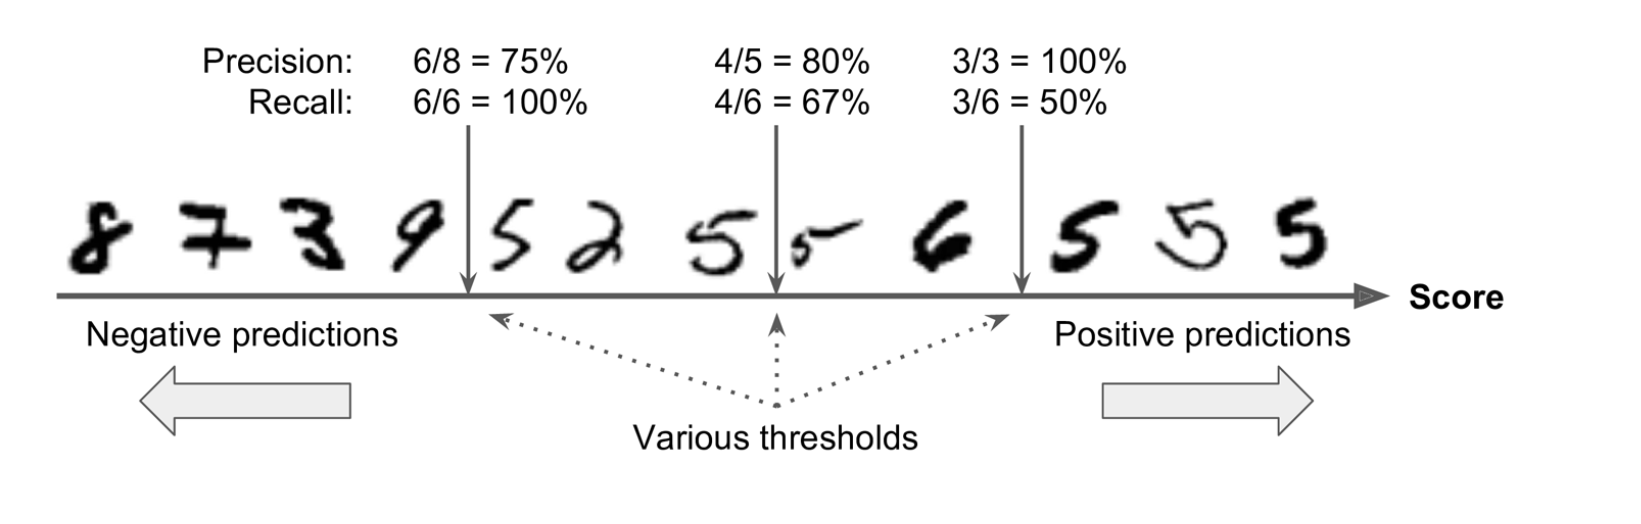

Raising the threshold:
- false positives can become true negatives, increasing precision
- true positives can become false negatives, decreasing recall

We can't set the threshold, but we have access to the decision scores and can call it's **decision_function()** which will return scores for any instance you feed it. You can make your own predicitons based on the scores it gives:

In [75]:
y_scores = sgd_clf.decision_function([ex_digit])
print("Example Score: ", y_scores)
threshold = 0
y_ex_digit_pred = (y_scores > threshold)
print("Prediction: ", y_ex_digit_pred)

Example Score:  [520541.31521371]
Prediction:  [ True]


SGD classifiers use a threshold of 0 (above code is thus the same as _predict()_). 

Raising the threshold:

In [76]:
threshold = 550000
y_ex_digit_pred = (y_scores > threshold)
print("Prediction, raised thresh: ", y_ex_digit_pred)

Prediction, raised thresh:  [False]


A much higher threshold, but it will cause a miss, decreasing recall.

We need a reasonable way to determine a threshold. We can use a cross validation function but specify it to return decision scores rather than predictions:

In [77]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_0, cv=3, method="decision_function")

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defa

Now, we can plot the precision and recall for all possible thresholds:

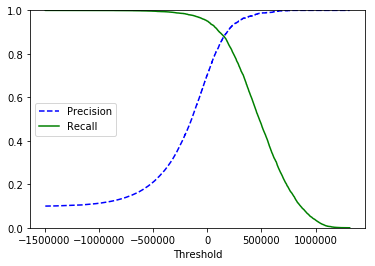

In [78]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="center left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

Right on!! We can then find the best precision/recall tradeoff for the given task. We can also plot precision directly against recall:

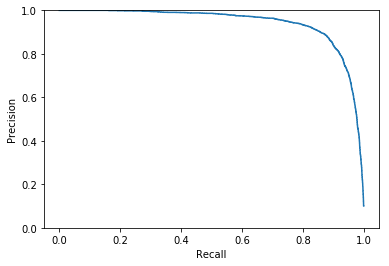

In [79]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.ylim([0, 1])
    
plot_precision_vs_recall(precisions, recalls)
plt.show()

After around 85-90% recall, precision drops drastically. We should choose a threshold before that precision dropoff.

How do we implement our new threshold? Take a look at the plot, see which one you'd like to use, and...

In [80]:
y_train_pred_200k = (y_scores > 200000)
print("Precision Score, 200k thresh: ", precision_score(y_train_0, y_train_pred_200k))
print("Recall Score, 200k thresh ", recall_score(y_train_0, y_train_pred_200k))

Precision Score, 200k thresh:  0.9120879120879121
Recall Score, 200k thresh  0.8407901401316901


That looks pretty darn good!

#### 3.2.2.3 - The ROC Curve

**Receiver Operating Characteristic (ROC)**: Plots _true positive rate_ (another name for recall) against _false positive rate_. It is a ratio of negative instances incorrectly classified as positive. It's a plot of _sensitivity_ v. _specifity_.

- _True Negative Rate_ (TNR): Recall, or _specificity_.
- _False Positive Rate_ (FPR): Ratio of negative instances that are incorrectly classified as positive, $FPR = 1 - TNR$

We can use the roc_curve function:

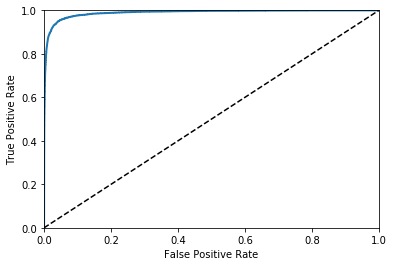

In [83]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()

A random classifier is represented by the dotted line. If your classifier beats this, way to go. 

The higher the TRP, the higher the FPR, the more false positives your system will produce.

We can also use the _area under the curve (AUC)_ metric. An _ROC AUC_ of a perfect classifier will have a parameter of 1 and a random one will have a metric of 0.5. 

Scikit-Learn provides a function for this:

In [84]:
from sklearn.metrics import roc_auc_score
print("ROC AUC Score, SGD: ", roc_auc_score(y_train_0, y_scores))

ROC AUC Score:  0.9888546503297548


#### 3.2.2.4 - Deciding between PR or ROC Curves

- **PR Curve**: use when...
 - _Positive_ class is rare
 - Care more about false positives than false negatives
- **ROC Curve**: use when...
 - _Negative_ class is rare
 - Care more about false negatives than false positives
 
The PR curve makes it clear this classifier needs improvement. The ROC curve makes it seem as if it is excellent. This is because there are few positives compared to negatives. The negative class is rare in our case. We probably shouldn't prefer it.

### 3.2.3 - Comparing Classifiers, SGD v. Random Forest

Let's train a RandomForestClassifier and compare its ROC curve.

RandomForest doesn't have a decision function. It has a "predict probability" method for each instance (Ex. this row has an 82% chance of being a 0). 

For ROC curves, we wanted scores. We could just use the positive class' probability as the score as a workaround:

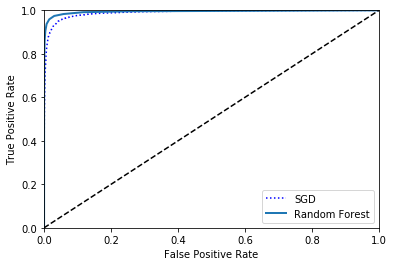

Precision Score, Random Forest:  0.9633554876953476
Recall Score, Random Forest:  0.9054533175755529
ROC AUC Score, Random Forest:  0.9943875465924988


In [93]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_0, cv=3, method="predict_proba")
y_scores_forest = y_probas_forest[:, 1]          # Set score equal to prob of positive class
fpr_forest, tpr_forest, thesholds_forest = roc_curve(y_train_0, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

prob_thresh_forest = 0.6
y_train_pred_forest = (y_scores_forest > prob_thresh_forest)

print("Precision Score, Random Forest: ", precision_score(y_train_0, y_train_pred_forest))
print("Recall Score, Random Forest: ", recall_score(y_train_0, y_train_pred_forest))
print("ROC AUC Score, Random Forest: ", roc_auc_score(y_train_0, y_scores_forest))


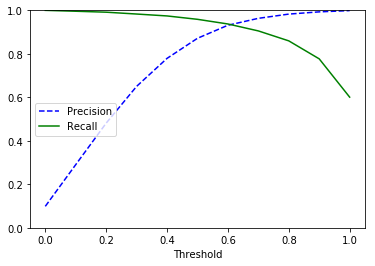

In [91]:
precisions_for, recalls_for, thresholds_for = precision_recall_curve(y_train_0, y_scores_forest)
plot_precision_recall_vs_threshold(precisions_for, recalls_for, thresholds_for)
plt.show()

Now that's not a bad classier!

### 3.2.4 Review of Binary Classification

So, what did we do?

- Defined a classifier
- Chose appropriate performance metrics
- Evaluate classifiers via cross-validation
- Based off performance, adjusted the classifier based off precision/recall tradeoff
- Compared classifiers based on the appropriate chosen metrics.

***

## 3.3 - Multiclass Classification

### 3.3.1 - Training a Multiclass Classifier (Ex. Stochiastic Gradient Decent, Random Forest, etc.)

**Multiclass/Multinomial Classifier**: Among all these classes, which one is this thing?

What can handle multiclass problems directly?
- Random Forest
- Naive Bayes

What are strictly binary classifiers?
- Support Vector Machine
- Linear

We could train a binary classifier for each class (Ex. from 0 to 9)! Feed the image and get the decision score from each classifier. Let the highest one win and this would be the _one v. all (OVA)_ technique.

We could train a binary classifier for each pair of classes (Ex. 0 v. 1, 0 v.2, ..., 1 v. 2,...). For $N$ classes we would need $\frac{N\times(N-1)}{N}$ classifiers. For N=10, this means 45 classifiers. Run the new image through all 45 classifiers and pick the one that wins the most battles. This would be the _one-versus-one (OvO)_ technique. Each classifier only needs to be trained on part of the training set w/ its dueling inputs. Support Vector Machine classifiers don't scale well with the size of training sets, so they may work better as OvO.

- OvA: Most binary classification algorithms
- OvO: Most classification algorithms that don't scale w/ training size

SciKit-Learn detects use of binary classification for multiclass uses and will automatically run OvA (except for SVMs). 

### 3.3.2 - Multiclass SGD

#### 3.3.2.1 - SGD - Multiclass Definition

Defining our multiclass SGD:

In [105]:
sgd_clf.fit(X_train, y_train)     #WE ARE TFITTING ON THE WHOLE TRAINING DATA, NOT y_train_0
print("Predicted Example, SGD Multiclass: ", sgd_clf.predict([ex_digit]))

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Predicted Example, SGD Multiclass:  [0.]


Boom! Trained and used to predict a random image, and correctly to boot!

Here, SciKit-Learn trained 10 binary classifiers, got the decision scores for the image, and chose the class w/ the highest score.

#### 3.3.2.2 - SGD - Decision Function

Recalling about the decision_function()

In [102]:
ex_digit_scores = sgd_clf.decision_function([ex_digit])
print("Example digit scores, SGD: ", ex_digit_scores)
print("Highest Scoring Class: ", sgd_clf.classes_[np.argmax(ex_digit_scores)])

Example digit scores, SGD:  [[ 520541.31521371 -654758.75565005 -390290.80202762 -365388.46730346
  -696087.0835339  -316208.02724901 -341272.55151958 -534721.04157662
  -296319.85489212 -358473.16373951]]
Highest Scoring Class:  0.0


**NOTE**: List of targets is stored in the "classes_" attributes. Almost never will the index match the class name, so you need to be able to call the class name. 

#### 3.3.2.3 - SGD - OvO v. OvA

To define the type of technique of multiclass classification, we will create a different instance and pass a specific binary classifier. Creating OvO:

In [103]:
from sklearn.multiclass import OneVsOneClassifier
ovo_SGD_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_SGD_clf.fit(X_train, y_train)
ovo_SGD_clf.predict([ex_digit])

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defa

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defa

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defa

array([0.])

### 3.3.3 - Multiclass Random Forest

#### 3.3.3.1 - Random Forest - Multiclass Definition

Again our similar definition for our Random Forest:

In [108]:
forest_clf.fit(X_train, y_train)              #SAME CONCERN. WE ARE FITTING TO y_train, NOT y_train_0
print("Predicted Example, Random Forest Multiclass: ", forest_clf.predict([ex_digit]))

Predicted Example, Random Forest Multiclass:  [0.]


Great! It looks like we have it working for now.

#### 3.3.3.2 - Random Forest - Finding Class Probabilities

We want our confidence scores for this image:

In [109]:
print("Predicted Probabilities, Random Forest Multiclass: ", forest_clf.predict_proba([ex_digit]))

Predicted Probabilities, Random Forest Multiclass:  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


### 3.3.4 - Evaluations and Improvements

#### 3.3.4.1 - Cross-Validation for SGD Multiclass

Use the same cross_val_score() function:

In [110]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defa

array([0.86157768, 0.86489324, 0.87918188])

Across our 3 test folds, we get about 86% accuracy! Much better than the 10% chance we would get for a random classifier.

#### 3.3.4.2 - Improving SGD Multiclass and Re-evaluation

Scaling inputs (seen in Ch. 2!!) increases our accuracy:

In [111]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and defa

array([0.9070186 , 0.90659533, 0.91193679])

A 4% improvement!!

### 3.3.5 -  Multiclass Error Analysis

